<a href="https://colab.research.google.com/github/titika2013/Made_adv_DL/blob/main/homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import glob
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore", category=mpl.cbook.mplDeprecation)
%matplotlib inline

#### Prepare

In [3]:
from PIL import Image


def read_path(path):
    all_path = "/content/drive/MyDrive/facades/" + path + "/"
    dataset = glob.glob(all_path + "*.jpg")
    return dataset


class Dataset(object):
    def __init__(self, path):
        self.files = read_path(path)
        self.trasformer = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    def _sep(self, img):
        img_np = np.array(img)
        mask_image = img_np[:, img.width // 2:]
        real_image = img_np[:, :img.width // 2]
        return mask_image, real_image

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('RGB')

        real, mask = self._sep(img)
        input_tensor = self.trasformer(real)
        output_tensor = self.trasformer(mask)
        return input_tensor, output_tensor

    def __len__(self):
        return len(self.files)


def show_img_sample(mask, real):
    fig, axes = plt.subplots(1, 2, figsize=(12, 12))
    ax = axes.ravel()
    ax[0].imshow(mask.permute(1, 2, 0))
    ax[0].set_title("mask image", c="g")
    ax[1].imshow(real.permute(1, 2, 0))
    ax[1].set_title("real image", c="g")

    plt.show()


In [4]:
train_ds = Dataset("train")
val_ds = Dataset("val")
test_ds = Dataset("test")

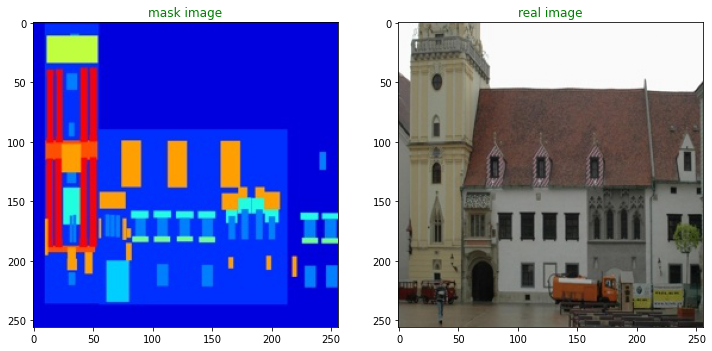

In [5]:
show_img_sample(train_ds[0][0], train_ds[0][1])

In [6]:
BATCH_SIZE = 11
SEED = 42
# torch.manual_seed(SEED)
# np.random.seed(SEED)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE , shuffle=True)
test_dl = DataLoader(val_ds, batch_size=2, shuffle=False)

### Pix2Pix

In [7]:
import torch
import torch.nn as nn


class batchnorm_relu_drop(nn.Module):
    def __init__(self, in_c):
        super().__init__()

        self.bn = nn.BatchNorm2d(in_c)
        self.lrelu = nn.LeakyReLU(0.2)
        self.drop = nn.Dropout(0.3)

    def forward(self, inputs):
        x = self.bn(inputs)
        x = self.lrelu(x)
        x = self.drop(x)
        return x


class res_blok(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()

        self.b1 = batchnorm_relu_drop(in_c)
        self.c1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
        self.b2 = batchnorm_relu_drop(out_c)
        self.c2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, stride=1)

        self.s = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0, stride=stride)

    def forward(self, inputs):
        x = self.b1(inputs)
        x = self.c1(x)
        x = self.b2(x)
        x = self.c2(x)
        s = self.s(inputs)

        skip = x + s
        return skip


class up_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.r = res_blok(in_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.r(x)
        return x


class Generator(nn.Module):
    def __init__(self, in_c=3, out_c=64):
        super().__init__()

        self.c11 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        # self.br1 = batchnorm_relu(out_c)

        self.r1 = res_blok(out_c, out_c * 2, stride=2)
        self.r2 = res_blok(out_c * 2, out_c * 4, stride=2)
        self.r3 = res_blok(out_c * 4, out_c * 8, stride=2)
        self.r4 = res_blok(out_c * 8, out_c * 8, stride=2)
        self.r5 = res_blok(out_c * 8, out_c * 8, stride=2)
        self.r6 = res_blok(out_c * 8, out_c * 8, stride=2)
        self.r7 = res_blok(out_c * 8, out_c * 8, stride=2)


        self.d1 = up_block(out_c * 8, out_c * 8)
        self.d2 = up_block(out_c * 8, out_c * 8)
        self.d3 = up_block(out_c * 8, out_c * 8)
        self.d4 = up_block(out_c * 8, out_c * 8)
        self.d5 = up_block(out_c * 8, out_c * 4)
        self.d6 = up_block(out_c * 4, out_c * 2)
        self.d7 = up_block(out_c * 2, out_c)


        self.output = nn.Conv2d(out_c, in_c, kernel_size=1)

    def forward(self, inputs):

        x = self.c11(inputs)


        skip1 = self.r1(x)
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)
        skip4 = self.r4(skip3)
        skip5 = self.r5(skip4)
        skip6 = self.r6(skip5)
        skip7 = self.r7(skip6)


        d1 = self.d1(skip7, skip6)
        d2 = self.d2(d1, skip5)
        d3 = self.d3(d2, skip4)
        d4 = self.d4(d3, skip3)
        d5 = self.d5(d4, skip2)
        d6 = self.d6(d5, skip1)
        d7 = self.d7(d6, x)

        output = self.output(d7)
        output = torch.nn.Tanh()(output)
        return output


In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_c=6, out_c=64):
        super().__init__()
        self.c11 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.r1 = res_blok(out_c, out_c * 2, stride=2)
        self.r2 = res_blok(out_c * 2, out_c * 4, stride=2)
        self.r3 = res_blok(out_c * 4, out_c * 8, stride=2)
        self.r4 = res_blok(out_c * 8, out_c * 8, stride=2)
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, inputs, x=None):
        x = torch.cat([inputs, x], dim=1)
        x = self.c11(x)

        skip1 = self.r1(x)
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)
        skip4 = self.r4(skip3)

        output = self.pooling(skip4)
        output = torch.nn.Sigmoid()(output)
        return output


In [9]:
def plot_res(mask_img, gen_img, real_img, epoch, num = 0):
    if num == 0:
     num = len(gen_img)
    fig, ax = plt.subplots(num, 3, figsize=(15, 55 * num), squeeze=False)
    for i in range(num):
        ax[i, 0].imshow(mask_img[i].permute(1, 2, 0))
        ax[i, 1].imshow(gen_img[i].permute(1, 2, 0))
        ax[i, 2].imshow(real_img[i].permute(1, 2, 0))
        ax[i, 0].set_title(f'mask epoch = {epoch}')
        ax[i, 1].set_title(f'generated image epoch = {epoch}')
        ax[i, 2].set_title(f'real epoch = {epoch}')
        plt.show()


In [ ]:
class Pix2pix():

    def __init__(self, num_epochs=50, test_dl=test_dl, train_dl=train_dl, generator_c=Generator,
                 discriminator_c=Discriminator):
        self.num_epochs = num_epochs

        self.test_input, self.test_target = test_dl.__iter__().__next__()
        self.train_dl = train_dl
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.generator = generator_c().to(self.device)
        self.discriminator = discriminator_c().to(self.device)

        self.b_loss = torch.nn.BCELoss().to(self.device)
        self.l_loss = torch.nn.L1Loss().to(self.device)

        self.gen_opt = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.disc_opt = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

        self.discriminator_losses = []
        self.generator_losses = []

    def train_pix(self):

        for epoch in tqdm(range(self.num_epochs), desc='Epoch'):
            disk_losses = []
            gen_losses = []

            for i, batch in tqdm(enumerate(self.train_dl), total=len(self.train_dl), leave=False, desc='Step'):
                mask_img, real_img = batch
                mask_img, real_img = Variable(mask_img.to(self.device)), Variable(real_img.to(self.device))

                x_real_logit = self.discriminator(mask_img, real_img)
                x_real_logit_ = torch.ones(x_real_logit.size())
                x_real_logit_ = Variable(x_real_logit_.to(self.device))
                x_real_loss = self.b_loss(x_real_logit, x_real_logit_)

                gen_image = self.generator(mask_img)

                x_fake_logit = self.discriminator(mask_img, gen_image)
                x_fake_logit_ = torch.zeros(x_fake_logit.size())
                x_fake_logit_ = Variable(x_fake_logit_.to(self.device))
                x_fake_loss = self.b_loss(x_fake_logit, x_fake_logit_)

                disc_loss_a = (x_real_loss + x_fake_loss) * 0.5
                self.discriminator.zero_grad()
                disc_loss_a.backward()
                self.disc_opt.step()

                gen_image = self.generator(mask_img)
                x_fake_logit = self.discriminator(mask_img, gen_image)
                gen_fake_loss = self.b_loss(x_fake_logit, x_real_logit_)

                l_loss = self.l_loss(gen_image, real_img)

                gen_loss = gen_fake_loss + l_loss * 100

                self.generator.zero_grad()
                gen_loss.backward()
                self.gen_opt.step()

                disk_losses.append(disc_loss_a.item())
                gen_losses.append(gen_loss.item())

                print('\rEpoch num {}, step {}, Discriminator loss: {:.4f}, Generator loss: {:.4f}, Generator  bce loss {:.4f}'.format \
                          (epoch + 1, i + 1, disc_loss_a.item(), gen_loss.item(), gen_fake_loss), end='', flush=True)
            disk_mean_loss = torch.mean(torch.FloatTensor(disk_losses))
            gen_mean_loss = torch.mean(torch.FloatTensor(gen_losses))
            self.discriminator_losses.append(disk_mean_loss)
            self.generator_losses.append(gen_mean_loss)
            gen_image = self.generator(Variable(self.test_input.to(self.device)))
            gen_image = gen_image.cpu().data
            if epoch % 5 == 0:
              plot_res(self.test_input, gen_image, self.test_target, epoch, 1)


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 1, step 37, Discriminator loss: 0.2773, Generator loss: 25.0217, Generator  bce loss 1.7889

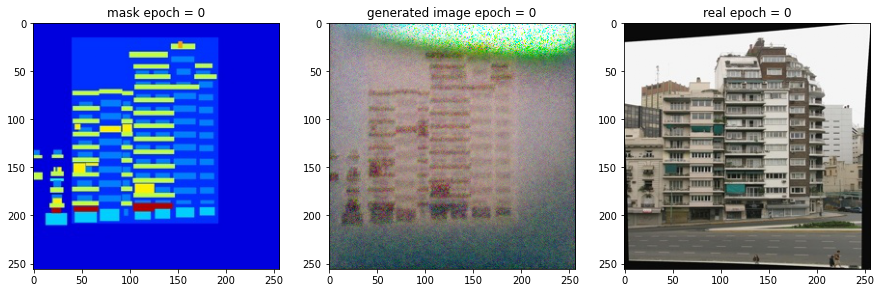

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 2, step 37, Discriminator loss: 0.8372, Generator loss: 16.4589, Generator  bce loss 0.7871

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 3, step 37, Discriminator loss: 0.2422, Generator loss: 20.4308, Generator  bce loss 1.8313

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 4, step 37, Discriminator loss: 0.3883, Generator loss: 23.4114, Generator  bce loss 3.4863

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 5, step 37, Discriminator loss: 0.4423, Generator loss: 25.5359, Generator  bce loss 4.1354

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 6, step 37, Discriminator loss: 0.1729, Generator loss: 19.8866, Generator  bce loss 2.8333

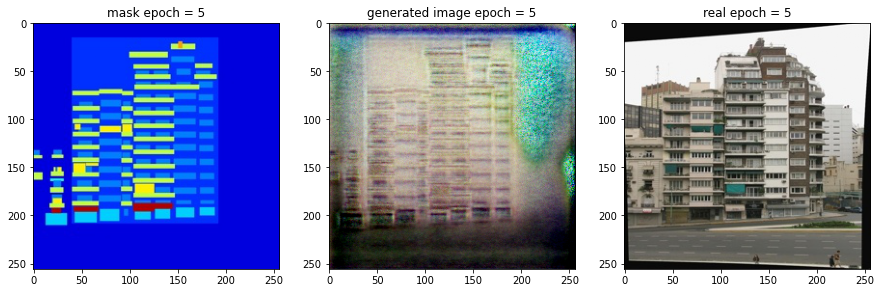

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 7, step 37, Discriminator loss: 0.3118, Generator loss: 18.7430, Generator  bce loss 1.2982

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 8, step 37, Discriminator loss: 1.0044, Generator loss: 19.2619, Generator  bce loss 0.1485

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 9, step 37, Discriminator loss: 0.7860, Generator loss: 23.8682, Generator  bce loss 3.6997

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 10, step 37, Discriminator loss: 0.6010, Generator loss: 27.5030, Generator  bce loss 3.2342

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 11, step 37, Discriminator loss: 0.2683, Generator loss: 20.6250, Generator  bce loss 2.4236

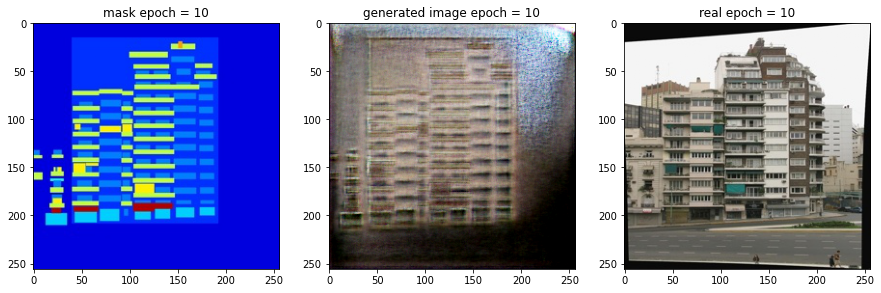

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 12, step 37, Discriminator loss: 0.2269, Generator loss: 21.8701, Generator  bce loss 2.7948

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 13, step 37, Discriminator loss: 0.2520, Generator loss: 18.0161, Generator  bce loss 2.5743

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 14, step 37, Discriminator loss: 0.9960, Generator loss: 22.0044, Generator  bce loss 1.7470

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 15, step 37, Discriminator loss: 0.3012, Generator loss: 20.9911, Generator  bce loss 1.9794

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 16, step 37, Discriminator loss: 0.9783, Generator loss: 20.5734, Generator  bce loss 0.8245

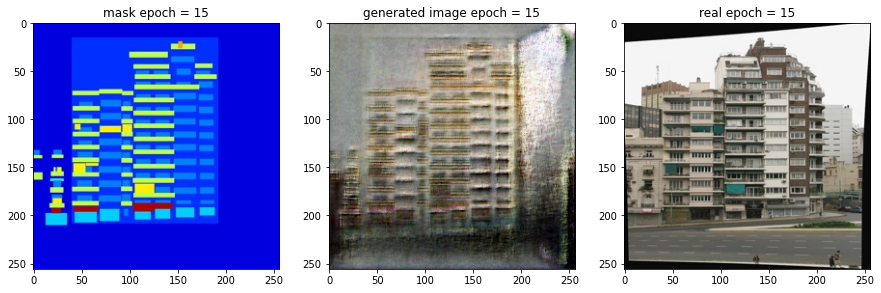

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 17, step 37, Discriminator loss: 0.5030, Generator loss: 22.4317, Generator  bce loss 2.3059

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 18, step 37, Discriminator loss: 0.7080, Generator loss: 20.0000, Generator  bce loss 0.9491

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 19, step 37, Discriminator loss: 0.4963, Generator loss: 24.0799, Generator  bce loss 3.0646

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 20, step 37, Discriminator loss: 0.7478, Generator loss: 21.4163, Generator  bce loss 1.4091

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 21, step 37, Discriminator loss: 0.6052, Generator loss: 17.8362, Generator  bce loss 0.7903

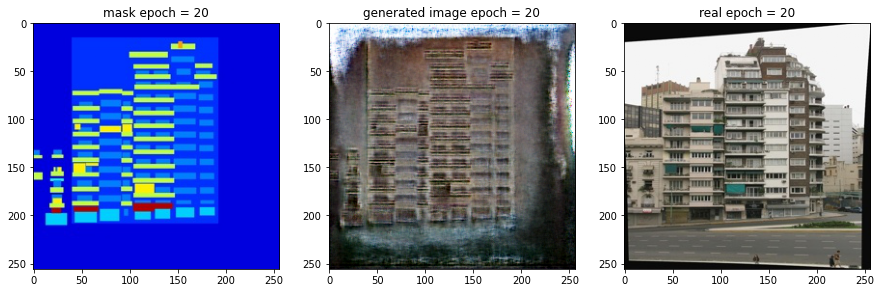

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 22, step 37, Discriminator loss: 0.4993, Generator loss: 15.5942, Generator  bce loss 0.8485

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 23, step 37, Discriminator loss: 0.5105, Generator loss: 20.3770, Generator  bce loss 1.8988

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 24, step 37, Discriminator loss: 0.4785, Generator loss: 17.2323, Generator  bce loss 2.4012

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 25, step 37, Discriminator loss: 0.1936, Generator loss: 17.9808, Generator  bce loss 1.5525

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 26, step 37, Discriminator loss: 0.4276, Generator loss: 16.0954, Generator  bce loss 0.6374

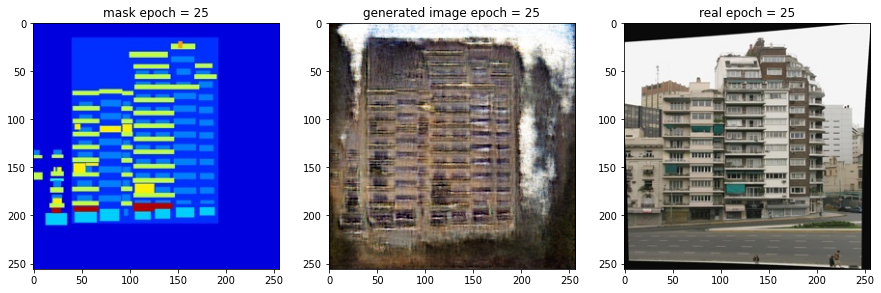

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 27, step 37, Discriminator loss: 0.5072, Generator loss: 17.6888, Generator  bce loss 1.0882

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 28, step 37, Discriminator loss: 0.2414, Generator loss: 14.9371, Generator  bce loss 1.3415

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 29, step 37, Discriminator loss: 0.6473, Generator loss: 14.7314, Generator  bce loss 0.3214

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 30, step 37, Discriminator loss: 0.4484, Generator loss: 19.3206, Generator  bce loss 2.3777

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 31, step 37, Discriminator loss: 0.3944, Generator loss: 15.3575, Generator  bce loss 1.6100

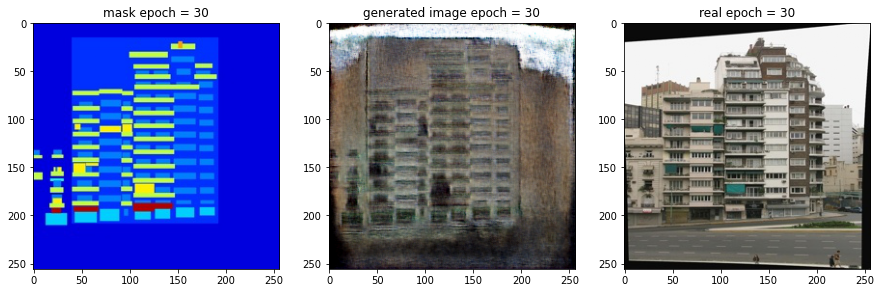

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 32, step 37, Discriminator loss: 0.8164, Generator loss: 17.1775, Generator  bce loss 0.3134

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 33, step 37, Discriminator loss: 0.4251, Generator loss: 15.3469, Generator  bce loss 0.7320

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 34, step 37, Discriminator loss: 0.5136, Generator loss: 17.1735, Generator  bce loss 1.2485

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 35, step 37, Discriminator loss: 1.2650, Generator loss: 17.0292, Generator  bce loss 0.6715

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 36, step 37, Discriminator loss: 0.4568, Generator loss: 16.9470, Generator  bce loss 2.9181

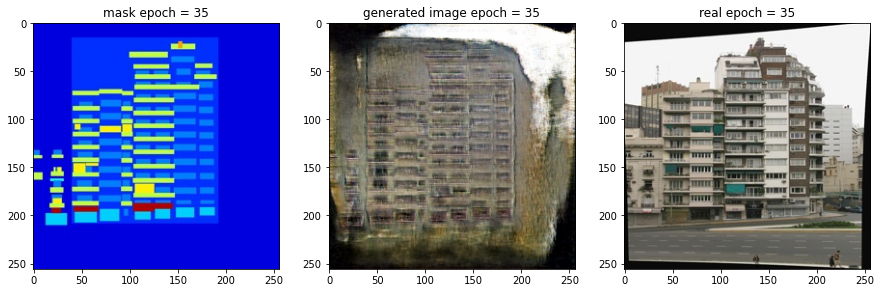

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 37, step 37, Discriminator loss: 1.0341, Generator loss: 12.9509, Generator  bce loss 0.5390

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 38, step 37, Discriminator loss: 0.4542, Generator loss: 16.8457, Generator  bce loss 1.4490

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 39, step 37, Discriminator loss: 1.2041, Generator loss: 15.2132, Generator  bce loss 0.7889

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 40, step 37, Discriminator loss: 0.2491, Generator loss: 17.7345, Generator  bce loss 1.3518

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 41, step 37, Discriminator loss: 0.4539, Generator loss: 16.2512, Generator  bce loss 1.2371

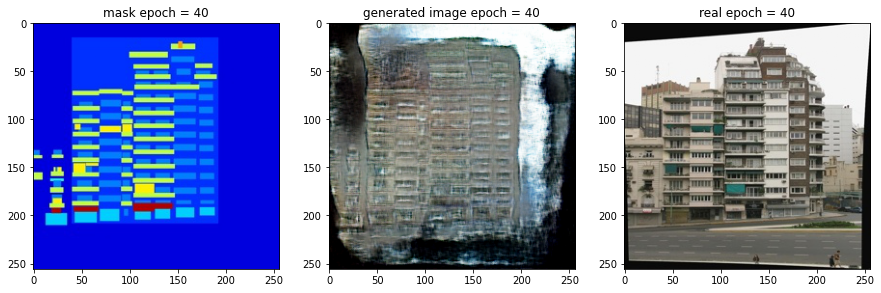

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 42, step 37, Discriminator loss: 0.2296, Generator loss: 16.9662, Generator  bce loss 2.0170

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 43, step 37, Discriminator loss: 0.4182, Generator loss: 16.3716, Generator  bce loss 2.8041

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 44, step 37, Discriminator loss: 0.4550, Generator loss: 13.9772, Generator  bce loss 0.6290

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 45, step 37, Discriminator loss: 0.9494, Generator loss: 13.8628, Generator  bce loss 0.3369

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 46, step 37, Discriminator loss: 0.4299, Generator loss: 15.1784, Generator  bce loss 1.4684

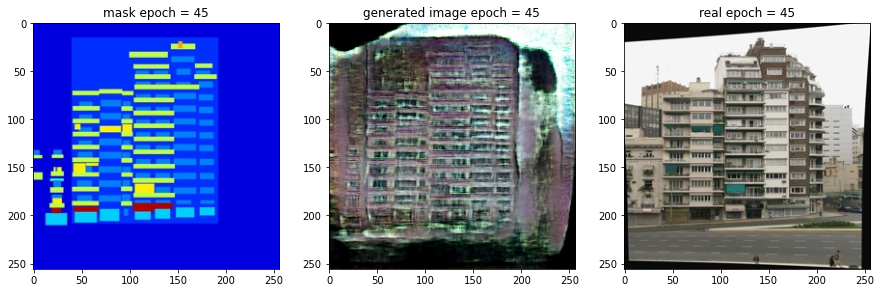

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 47, step 37, Discriminator loss: 0.5416, Generator loss: 13.9851, Generator  bce loss 0.5104

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 48, step 37, Discriminator loss: 0.8853, Generator loss: 12.7825, Generator  bce loss 0.4077

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 49, step 37, Discriminator loss: 0.2981, Generator loss: 15.6056, Generator  bce loss 1.3835

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 50, step 37, Discriminator loss: 0.5119, Generator loss: 12.8987, Generator  bce loss 0.7186

In [11]:
pix_model = Pix2pix()
pix_model.train_pix()

In [10]:
def loss_plot(arr, name=""):
    sns.set_style("darkgrid")
    plt.plot(arr)
    plt.title(f"{name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


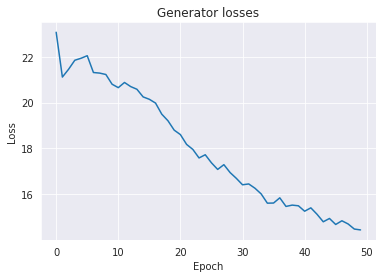

In [13]:
loss_plot(pix_model.generator_losses, name="Generator losses")

Generator loss снижался

## Вторая часть -- реализация CycleGAN

In [11]:
from PIL import Image



def read_path(path):
    all_path = "/content/drive/MyDrive/facades/" + path + "/"
    dataset = glob.glob(all_path + "*.jpg")
    return dataset


class Dataset_new(object):
    def __init__(self, path):
        self.files = read_path(path)
        self.trasformer = transforms.Compose([

            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    def _sep(self, img):
        img_np = np.array(img)
        mask_image = img_np[:, img.width // 2:]
        real_image = img_np[:, :img.width // 2]
        return mask_image, real_image

    def __getitem__(self, idx):
        img_1 = Image.open(random.choice(self.files)).convert('RGB')
        img_2 = Image.open(random.choice(self.files)).convert("RGB")
        width = img_2.width
        img_11 = np.array(img_1)[:, width // 2:]
        img_22 = np.array(img_2)[:, :width // 2]
        return self.trasformer(img_11), self.trasformer(img_22)

    def __len__(self):
        return len(self.files)


train_ds = Dataset_new("train")
train_dl_2 = torch.utils.data.DataLoader(train_ds, batch_size=3, shuffle=True)

val_ds = Dataset("val")
val_dl_2 = torch.utils.data.DataLoader(val_ds, batch_size=5, shuffle=False)


In [12]:
class Discriminator_new(nn.Module):
    def __init__(self, in_c=3, out_c=64):
        super().__init__()

        self.c11 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        # self.br1 = batchnorm_relu(out_c)
        self.r1 = res_blok(out_c, out_c * 2, stride=2)
        self.r2 = res_blok(out_c * 2, out_c * 4, stride=2)
        self.r3 = res_blok(out_c * 4, out_c * 8, stride=2)
        self.r4 = res_blok(out_c * 8, out_c * 8, stride=2)


        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.c11(x)
        skip1 = self.r1(x)
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)
        skip4 = self.r4(skip3)

        output = self.pooling(skip4)
        output = output.squeeze(-1).squeeze(-1)
        output = torch.nn.Sigmoid()(output)
        return output


In [13]:
def plot_res_2(mask_img, gen_img, real_img, epoch, num = 0):
    if num == 0:
     num = len(gen_img)
    fig, ax = plt.subplots(num, 3, figsize=(15, 55 * num), squeeze=False)
    for i in range(num):
        ax[i, 0].imshow(mask_img[i].permute(1, 2, 0))
        ax[i, 1].imshow(gen_img[i].permute(1, 2, 0))
        ax[i, 2].imshow(real_img[i].permute(1, 2, 0))
        ax[i, 0].set_title(f'mask epoch = {epoch}')
        ax[i, 1].set_title(f'generated image epoch = {epoch}')
        ax[i, 2].set_title(f'real epoch = {epoch}')
    plt.show()

In [14]:
class Cycle_Gan:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f'device={self.device}')
        self.gen_1 = Generator().to(self.device)
        self.gen_2 = Generator().to(self.device)
        self.disc_1 = Discriminator_new().to(self.device)
        self.disc_2 = Discriminator_new().to(self.device)

        self.desc_1_opt = torch.optim.Adam(self.disc_1.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.desc_2_opt = torch.optim.Adam(self.disc_2.parameters(), lr=2e-4, betas=(0.5, 0.999))

        self.gen_opt = torch.optim.Adam(list(self.gen_1.parameters()) + list(self.gen_2.parameters()),
                                        lr=1e-4)
        self.l_loss = torch.nn.L1Loss()
        self.bce_loss = torch.nn.CrossEntropyLoss()

        self.disc_1_all_loss_mean = []
        self.disc_2_all_loss_mean = []
        self.gen_1_2_all_loss_mean = []
        self.epochs = 50
    def train_cycle(self):

        for epoch in tqdm(range(self.epochs ), desc='Epoch'):
            disc_1_all_loss_ = []
            disc_2_all_loss_ = []
            gen_1_2_all_loss_ = []
            for i, batch in tqdm(enumerate(train_dl_2), total=len(train_dl_2), leave=False, position=0, desc='Step'):
                mask_img, real_img = batch
                mask_img = mask_img.to(self.device)
                real_img = real_img.to(self.device)

                gen_img = self.gen_1(mask_img)
                gen_mask = self.gen_2(real_img)
                gen_mask_l = self.disc_1(gen_mask)
                real_mask_l = self.disc_1(mask_img)
                gen_img_l = self.disc_2(gen_img)
                real_img_l = self.disc_2(real_img)

                gen_loss_disc_1 = self.bce_loss(gen_mask_l, torch.zeros(gen_mask_l.shape[0]).long().to(self.device))
                real_loss_disc_1 = self.bce_loss(real_mask_l, torch.ones(real_mask_l.shape[0]).long().to(self.device))
                disc_1_all_loss = (gen_loss_disc_1 + real_loss_disc_1) / 2
                self.desc_1_opt.zero_grad()
                disc_1_all_loss.backward()
                self.desc_1_opt.step()

                gen_loss_disc_2 = self.bce_loss(gen_img_l,
                                                torch.zeros(gen_img_l.shape[0]).long().to(
                                                    self.device))
                real_loss_disc_2 = self.bce_loss(real_img_l,
                                                 torch.ones(real_img_l.shape[0]).long().to(self.device))
                disc_2_all_loss = (gen_loss_disc_2 + real_loss_disc_2) / 2
                self.desc_2_opt.zero_grad()
                disc_2_all_loss.backward()
                self.desc_2_opt.step()

                gen_img = self.gen_1(mask_img)
                gen_mask = self.gen_2(real_img)
                generated_images_cycle = self.gen_1(gen_mask)
                generated_masks_cycle = self.gen_2(gen_img)
                gen_l1_loss = (self.l_loss(mask_img, generated_masks_cycle) + self.l_loss(real_img,
                                                                                          generated_images_cycle)) / 2
                gen_l2_loss = (self.l_loss(mask_img, gen_mask) + self.l_loss(real_img,
                                                                             gen_img)) / 2
                gen_mask_l = self.disc_1(gen_mask)
                gen_img_l = self.disc_2(gen_img)
                gen_1_bce = self.bce_loss(gen_img_l,
                                          torch.ones(gen_img_l.shape[0]).long().to(self.device))
                gen_2_bce = self.bce_loss(gen_mask_l,
                                          torch.ones(gen_mask_l.shape[0]).long().to(self.device))
                gen_1_2_all_loss = 20 * gen_l1_loss + gen_1_bce + 20 * gen_l2_loss + gen_2_bce
                self.gen_opt.zero_grad()
                gen_1_2_all_loss.backward()
                self.gen_opt.step()

                print(
                    '\rEpoch num {}, step {}, Discriminator 1 loss: {:.4f}, Discriminator 2 loss: {:.4f}, Generator loss {:.4f}'.format \
                        (epoch + 1, i + 1, disc_1_all_loss.item(), disc_2_all_loss.item(), gen_1_2_all_loss.item()),
                    end='', flush=True)
                disc_1_all_loss_.append(disc_1_all_loss.item())
                disc_2_all_loss_.append(disc_2_all_loss.item())
                gen_1_2_all_loss_.append(gen_1_2_all_loss.item())
            
            
            if epoch % 5 == 0:
                batch = next(iter(val_dl_2))
                masks_2, images_2  = batch
                masks_2 = masks_2.to(self.device)
                with torch.no_grad():
                    generated = self.gen_1(masks_2)
                    plot_res_2(masks_2.cpu(), generated.cpu(), images_2.cpu(), epoch, 1)

                    
        self.disc_1_all_loss_mean.append(np.mean(disc_1_all_loss_))
        self.disc_2_all_loss_mean.append(np.mean(disc_2_all_loss_))
        self.gen_1_2_all_loss_mean.append(np.mean(gen_1_2_all_loss_))


device=cuda


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 1, step 134, Discriminator 1 loss: 5.2452, Discriminator 2 loss: 5.2452, Generator loss 19.8630

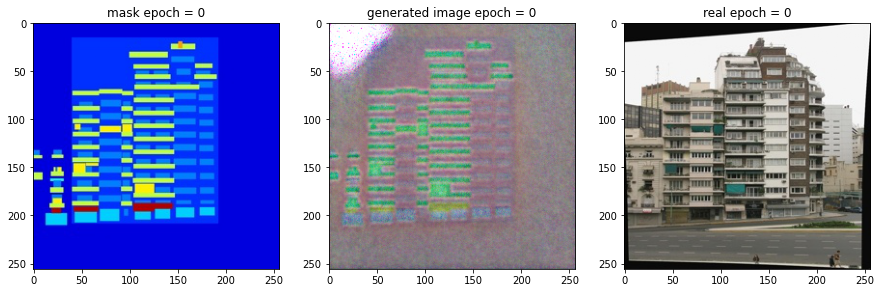

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 2, step 134, Discriminator 1 loss: 5.2451, Discriminator 2 loss: 5.2451, Generator loss 17.4704

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 3, step 134, Discriminator 1 loss: 5.2450, Discriminator 2 loss: 5.2450, Generator loss 16.0660

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 4, step 134, Discriminator 1 loss: 5.2450, Discriminator 2 loss: 5.2450, Generator loss 15.3341

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 5, step 134, Discriminator 1 loss: 5.2450, Discriminator 2 loss: 5.2450, Generator loss 18.5334

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 6, step 134, Discriminator 1 loss: 5.2450, Discriminator 2 loss: 5.2450, Generator loss 16.2994

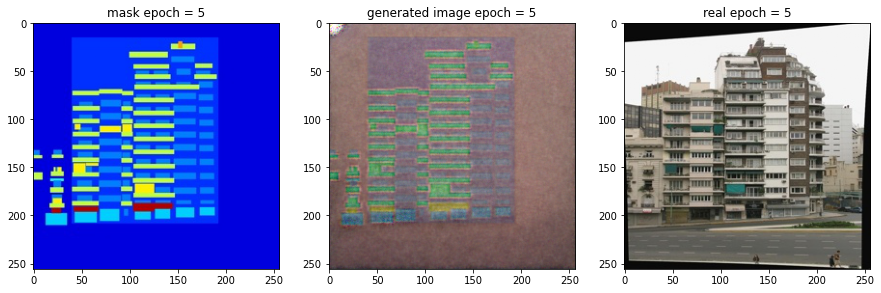

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 7, step 134, Discriminator 1 loss: 5.2450, Discriminator 2 loss: 5.2450, Generator loss 15.5934

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 8, step 134, Discriminator 1 loss: 5.2450, Discriminator 2 loss: 5.2450, Generator loss 15.2296

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 9, step 134, Discriminator 1 loss: 5.2450, Discriminator 2 loss: 5.2450, Generator loss 15.7353

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 10, step 134, Discriminator 1 loss: 5.2450, Discriminator 2 loss: 5.2450, Generator loss 16.4917

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 11, step 134, Discriminator 1 loss: 5.2450, Discriminator 2 loss: 5.2450, Generator loss 16.7759

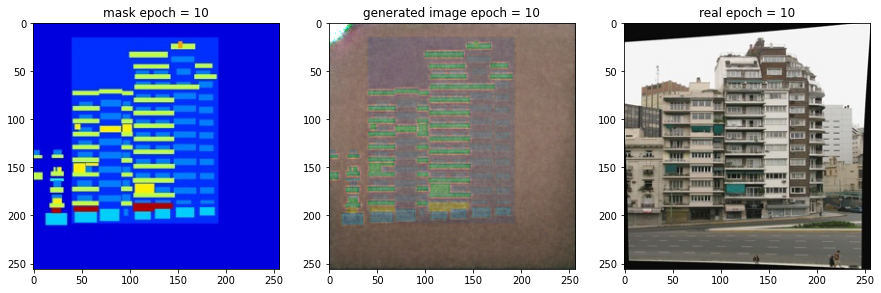

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 12, step 64, Discriminator 1 loss: 5.2450, Discriminator 2 loss: 5.2450, Generator loss 16.0467

In [ ]:
%%time
cycle_gan_model = Cycle_Gan()
cycle_gan_model.train_cycle()


In [ ]:
loss_plot(cycle_gan_model.gen_1_2_all_loss_mean, name="Generator losses")

К сожалению из-за нехватки времени не удалось доделать и нормально протестировать.